In [75]:
#opérations mathématiques
import numpy as np
import scipy.stats as stats

#data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from datetime import datetime

#manipulation de tableaux de données
import pandas as pd

#regression linéaire, séries de fourier
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

#affiche de l'ACF et PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#test de stationarité
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

#modèle ARMA
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess

#mesure des erreurs
from sklearn.metrics import mean_squared_error

#barre de progression
from tqdm import tqdm

In [76]:
dir = "C:\\Users\\asola\\Downloads\\consommation-quotidienne-brute.xlsx"
df = pd.read_excel(dir)

In [77]:
data = df[["Date - Heure","Consommation brute électricité (MW) - RTE"]]

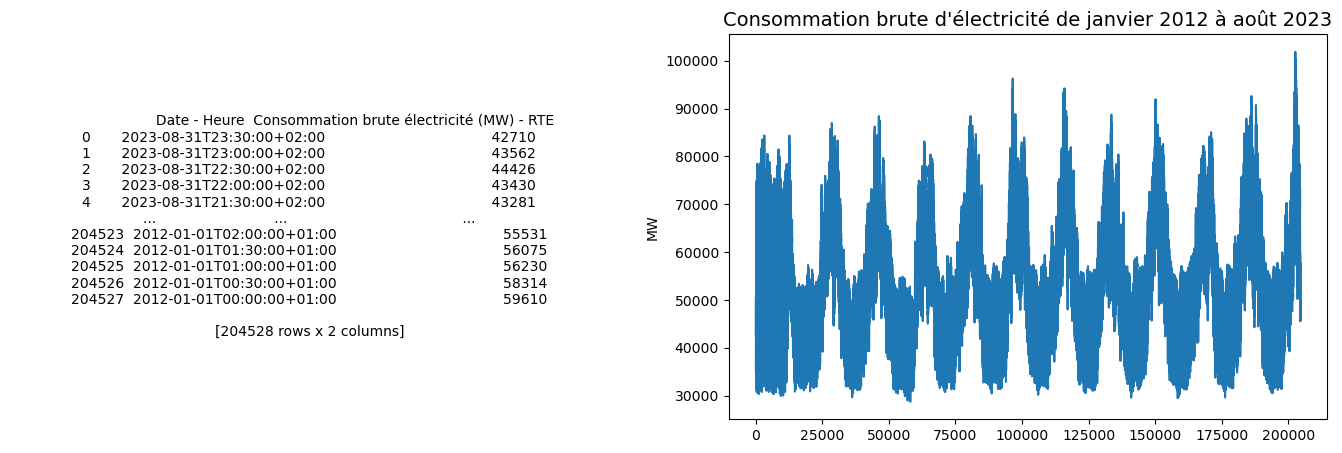

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
ax2.plot(data["Consommation brute électricité (MW) - RTE"])
ax2.set_title("Consommation brute d'électricité de janvier 2012 à août 2023",fontsize=14)
ax1.text(0.5, 0.5, str(data), fontsize=10, va='center', ha='center')
ax1.axis('off')
ax2.set_ylabel("MW")
plt.show()

In [79]:
copy = data.copy()
copy['Date - Heure'] = pd.to_datetime(copy['Date - Heure'], utc=True)

In [80]:
data_fi = copy.groupby(copy['Date - Heure'].dt.date)['Consommation brute électricité (MW) - RTE'].sum().reset_index()

In [81]:
data_fi['Date - Heure'] = pd.to_datetime(data_fi['Date - Heure'])
date_debut = '2012-01-01'
date_fin = '2021-12-31'
data_final = data_fi.loc[(data_fi['Date - Heure'] >= date_debut) & (data_fi['Date - Heure'] <= date_fin)]

In [82]:
data_final = data_final.copy()
data_final.rename(columns={'Date - Heure': 'Date'}, inplace=True)

In [83]:
data_final = data_final.copy()
data_final.rename(columns={"Consommation brute électricité (MW) - RTE": "Consommation brute d'électricité (MW)"}, inplace=True)

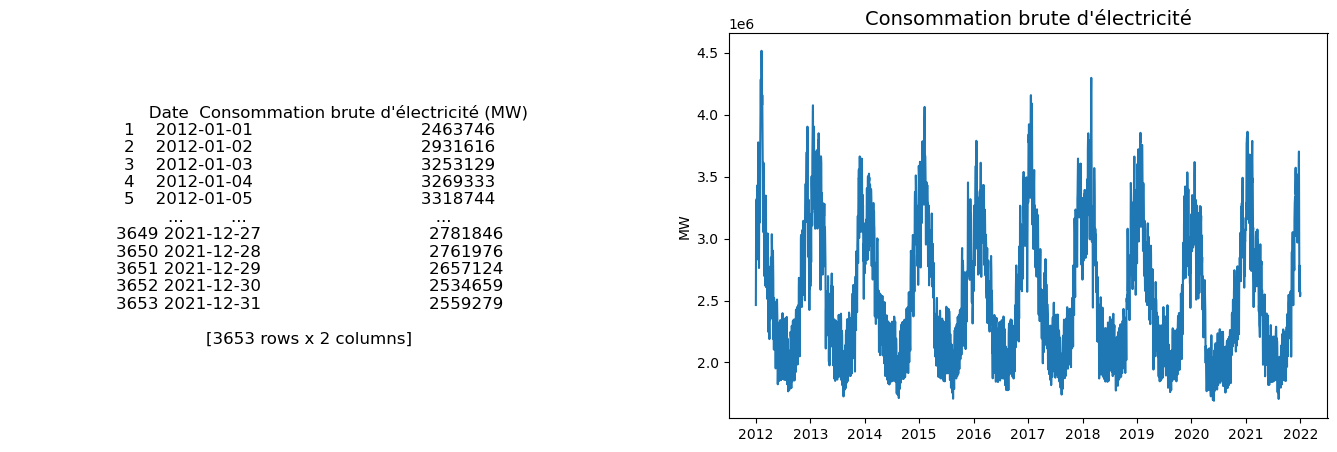

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
ax2.plot(data_final['Date'], data_final["Consommation brute d'électricité (MW)"])
ax2.set_title("Consommation brute d'électricité", fontsize=14)
ax2.set_ylabel("MW")
ax1.text(0.5, 0.5, str(data_final), fontsize=12, va='center', ha='center')
ax1.axis('off')
plt.show()

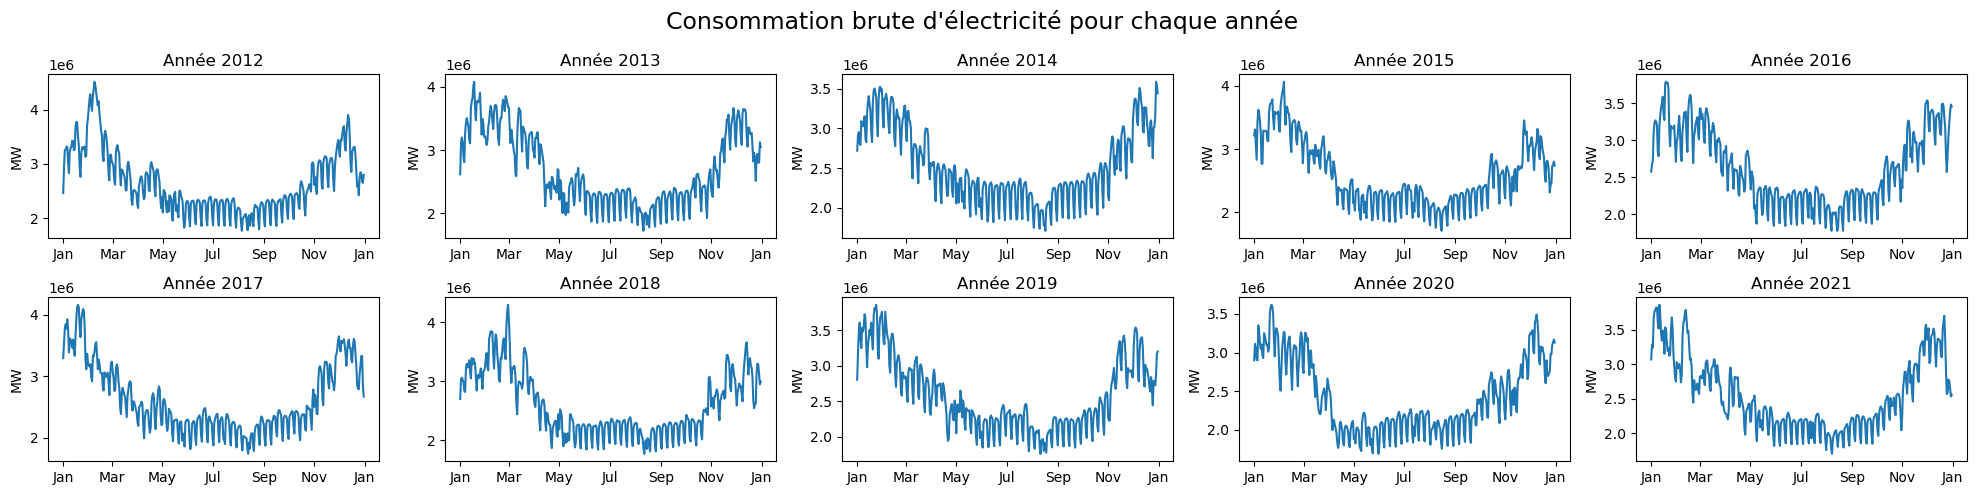

In [85]:
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
fig.suptitle("Consommation brute d'électricité pour chaque année", fontsize=17)

annees = data_final['Date'].dt.year.unique()

for i, annee in enumerate(annees):
    subset = data_final[data_final['Date'].dt.year == annee]
    row, col = i // num_cols, i % num_cols
    
    axes[row, col].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    axes[row, col].plot(subset['Date'], subset["Consommation brute d'électricité (MW)"])
    axes[row, col].set_title(f'Année {annee}')
    
    axes[row, col].set_ylabel('MW')
    axes[row, col].grid(False)
    
for i in range(len(annees), num_rows * num_cols):
    row, col = i // num_cols, i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()

plt.show()

In [86]:
data_fi['Date - Heure'] = pd.to_datetime(data_fi['Date - Heure'])
date_debut = '2022-01-01'
date_fin = '2022-12-31'
data_final_test = data_fi.loc[(data_fi['Date - Heure'] >= date_debut) & (data_fi['Date - Heure'] <= date_fin)]
data_final_test = data_final_test.copy()
data_final_test.rename(columns={'Date - Heure': 'Date'}, inplace=True)
data_final_test.rename(columns={"Consommation brute électricité (MW) - RTE": "Consommation brute d'électricité (MW)"}, inplace=True)

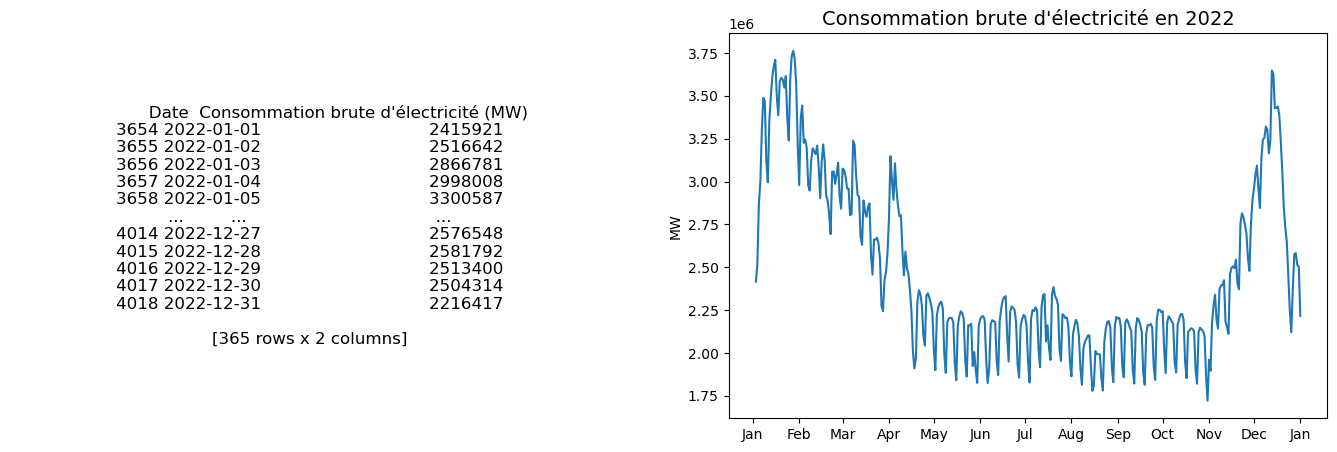

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
ax2.plot(data_final_test["Consommation brute d'électricité (MW)"])
ax2.set_title("Consommation brute d'électricité en 2022",fontsize=14)
ax1.text(0.5, 0.5, str(data_final_test), fontsize=12, va='center', ha='center')
ax1.axis('off')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.set_ylabel("MW")
plt.show()

In [88]:
# On décompose notre série en f(t) + S(t) + Xt avec 
# f(t) linéaire de la forme ax+b
# S(t) périodique avec S(t) = S(t+T) où T est la période
# Xt série stationnaire

In [89]:
data_final_train = data_final

dp = DeterministicProcess(
    index=data_final_train["Consommation brute d'électricité (MW)"].index,  
    constant=True,       
    order=1,             
    drop=True,           
)

X = dp.in_sample()

y = data_final_train["Consommation brute d'électricité (MW)"]  
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [90]:
print('f(t) =', model.coef_[0], model.coef_[1],'*t')

f(t) = 2687894.7001258396 -53.034960964324455 *t


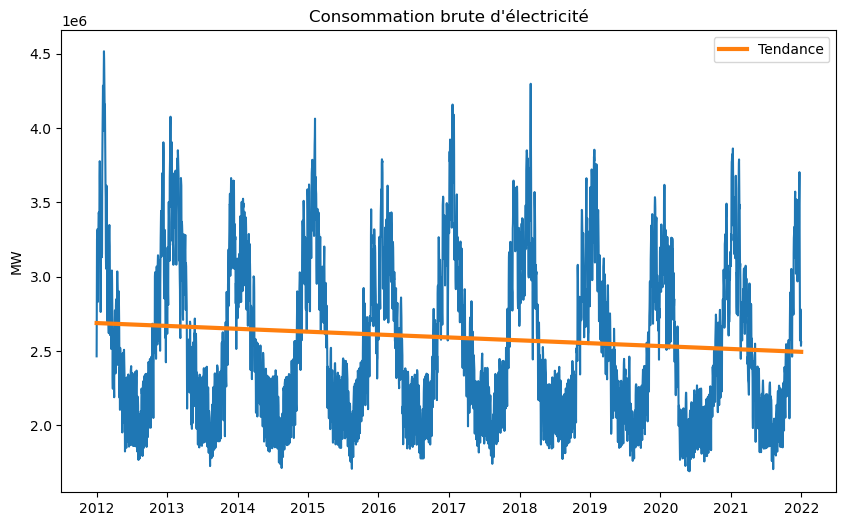

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(data_final_train["Date"], data_final_train["Consommation brute d'électricité (MW)"], linestyle="-")
plt.plot(data_final_train["Date"], y_pred, linewidth=3, label="Tendance")
plt.title("Consommation brute d'électricité")
plt.ylabel("MW")
plt.legend()
plt.show()

In [92]:
# on cherche à prédire les valeurs de f(t) pour l'année 2022
X = dp.out_of_sample(steps=365)
y_fore = pd.Series(model.predict(X), index=X.index)

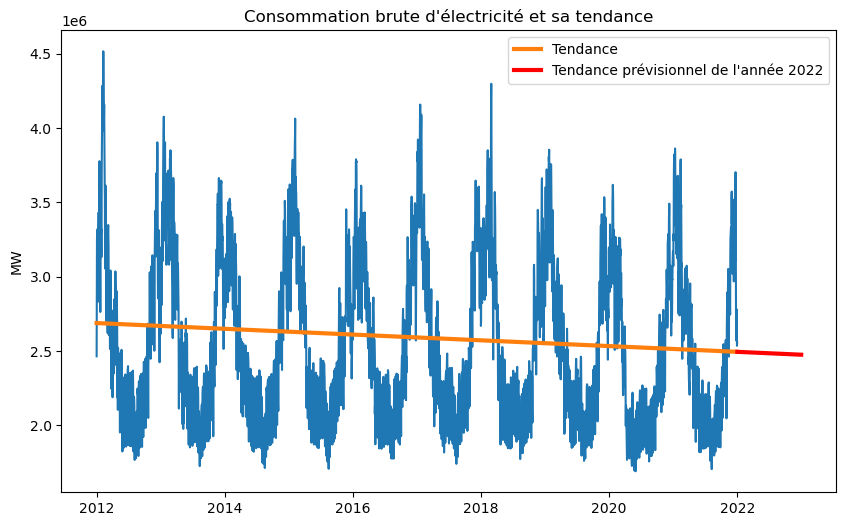

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(data_final_train["Date"], data_final_train["Consommation brute d'électricité (MW)"])
plt.plot(data_final_train["Date"], y_pred, linewidth=3, label="Tendance")
plt.plot(data_final_test["Date"], y_fore, linewidth=3, label="Tendance prévisionnel de l'année 2022", color='r')
plt.title("Consommation brute d'électricité et sa tendance")
plt.ylabel("MW")
plt.legend()
plt.show()

In [94]:
# on a donc obtenu la prediction de f(t) pour l'année 2022
# on cherche maintenant la périodicité et pour cela on commence par enlever la tendance de notre série temporelle

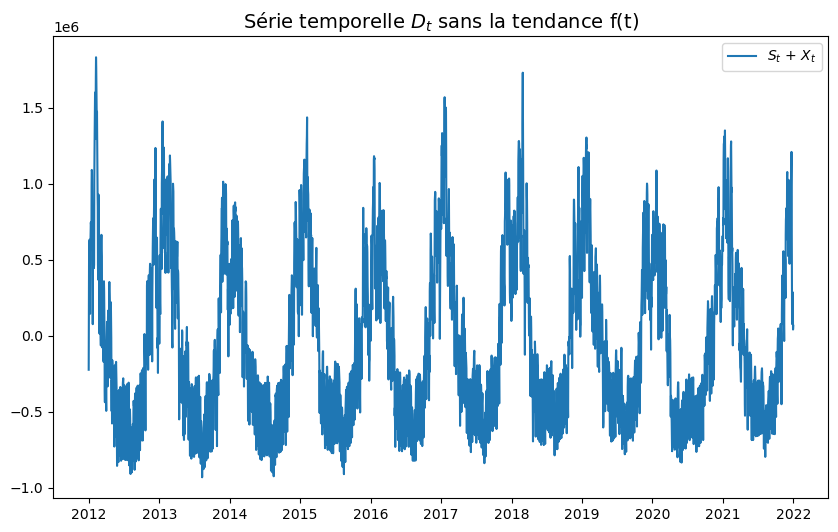

In [95]:
data_train_without_trend = data_final_train["Consommation brute d'électricité (MW)"]-y_pred

plt.figure(figsize=(10, 6))
plt.plot(data_final_train["Date"],data_train_without_trend, label='$S_{t}$ + $X_{t}$')
plt.title("Série temporelle $D_{t}$ sans la tendance f(t)", fontsize=14)
plt.legend()
plt.show()

In [96]:
# on cherche maintenant la périodicité avec différents boxplot

In [97]:
# on remet la colonne avec l'heure et la date

data_train_without_trend = pd.concat([data_final_train["Date"], data_train_without_trend], axis=1)
data_train_without_trend.rename(columns={0: "Consommation brute d'électricité (MW)"}, inplace=True)

In [98]:
data_train_without_trend_copy = data_train_without_trend.copy()

data_train_without_trend_copy['Date'] = pd.to_datetime(data_train_without_trend_copy['Date'])

# Créer une nouvelle colonne pour le jour de la semaine (0 = Lundi, 1 = Mardi, ..., 6 = Dimanche)
data_train_without_trend_copy['Day_of_Week'] = data_train_without_trend_copy['Date'].dt.dayofweek

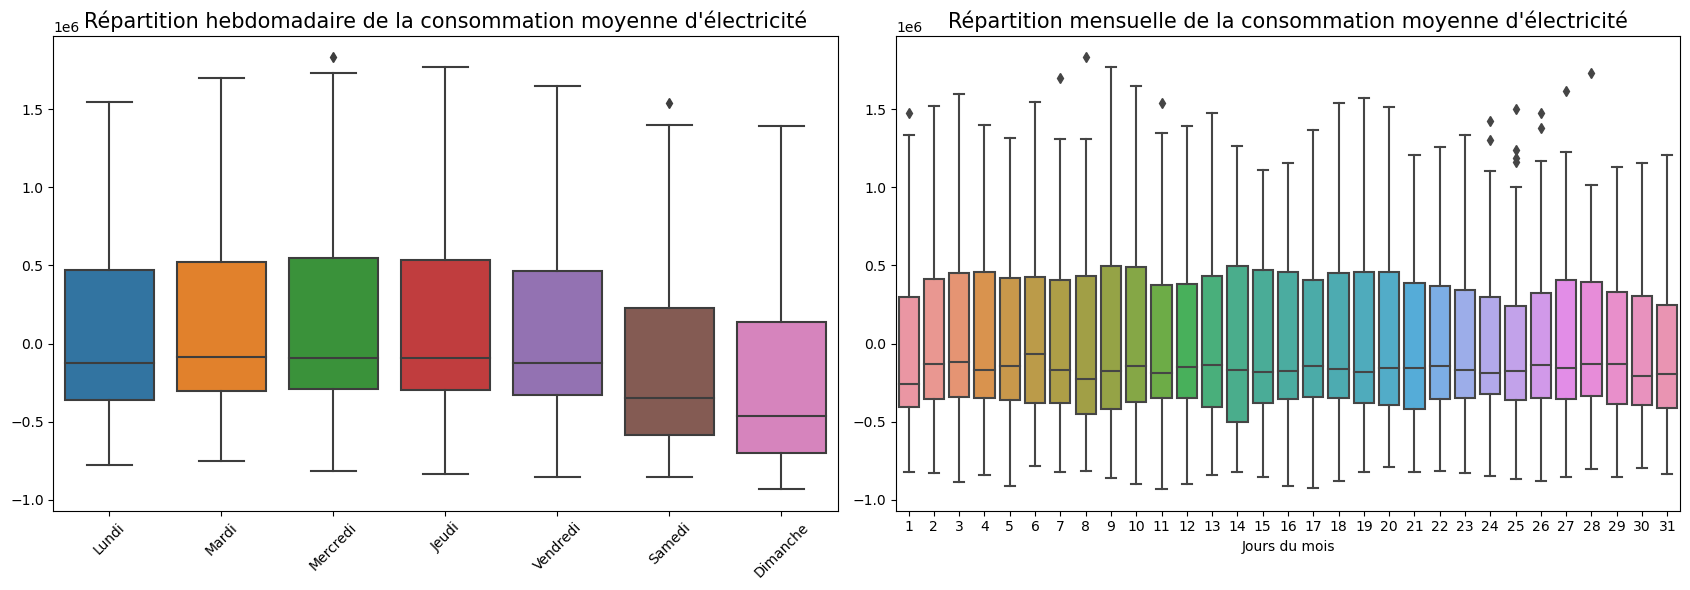

In [99]:
plt.figure(figsize=(17, 6))

# Premier sous-graphique : Répartition hebdomadaire
plt.subplot(1, 2, 1)
sns.boxplot(x=data_train_without_trend_copy['Day_of_Week'], y=data_train_without_trend_copy["Consommation brute d'électricité (MW)"])
plt.title("Répartition hebdomadaire de la consommation moyenne d'électricité", fontsize=15)
plt.xticks(range(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], rotation=45)
plt.xlabel('')
plt.ylabel('')

# Deuxième sous-graphique : Répartition mensuelle
plt.subplot(1, 2, 2)
sns.boxplot(x=data_train_without_trend['Date'].dt.day, y=data_train_without_trend["Consommation brute d'électricité (MW)"])
plt.title("Répartition mensuelle de la consommation moyenne d'électricité", fontsize=15)
plt.xlabel('Jours du mois')
plt.ylabel('')

plt.tight_layout()
plt.show()

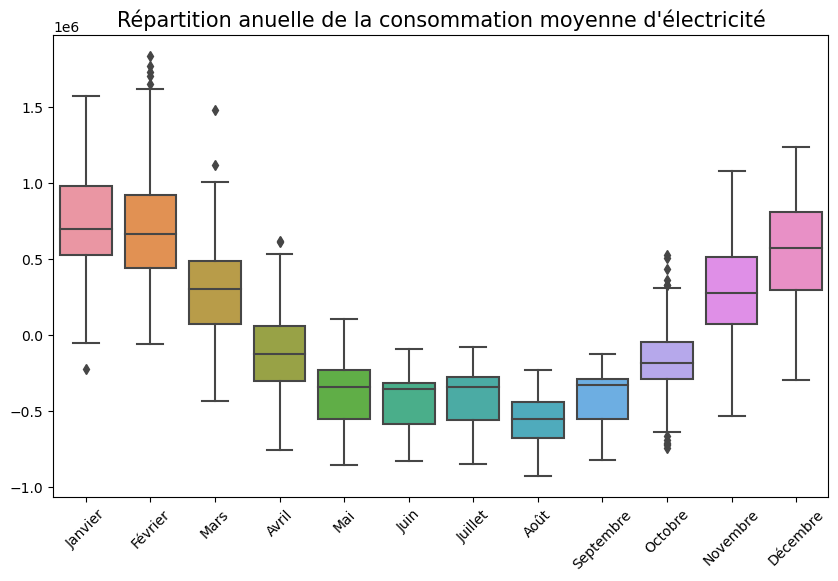

In [100]:
data_train_without_trend['Date'] = pd.to_datetime(data_train_without_trend['Date'])

# Tracé du diagramme de dispersion saisonnier
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_train_without_trend['Date'].dt.month, y=data_train_without_trend["Consommation brute d'électricité (MW)"])
plt.title("Répartition anuelle de la consommation moyenne d'électricité", fontsize=15)
plt.xticks(range(12), ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre'], rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [101]:
# on voit une grosse saisonalité dans l'année mais pas spécialement de saisonalité significative à plus petite échelle

# on peut essayer d'estimer la périodicité en faisant la moyenne de chaque jour de l'année sur les 10 années 
# de train donc avec une periode de 365 jours

In [102]:
data_train_without_trend_copy = data_train_without_trend.copy()
data_train_without_trend_copy['Date'] = pd.to_datetime(data_train_without_trend_copy['Date'])

# Créer une colonne 'Jour-Mois' pour ignorer l'année
data_train_without_trend_copy['Jour-Mois'] = data_train_without_trend_copy['Date'].dt.strftime('%m-%d')

# Calculer la somme par jour, indépendamment de l'année
daily_sum = data_train_without_trend_copy.groupby('Jour-Mois')["Consommation brute d'électricité (MW)"].sum().reset_index()

In [103]:
# On divise par 10 car on veut la valeure moyenne sur les 10 années

daily_sum["Consommation brute d'électricité (MW)"] = daily_sum["Consommation brute d'électricité (MW)"] /10

# on enlève le 29 février sur notre periode car 2022 n'est pas bissextile donc on n'a pas besoin de prédire cette valeur

periode = daily_sum.copy()
periode = periode.drop(periode[periode["Jour-Mois"] == '02-29'].index)
periode = periode.reset_index(drop=True)

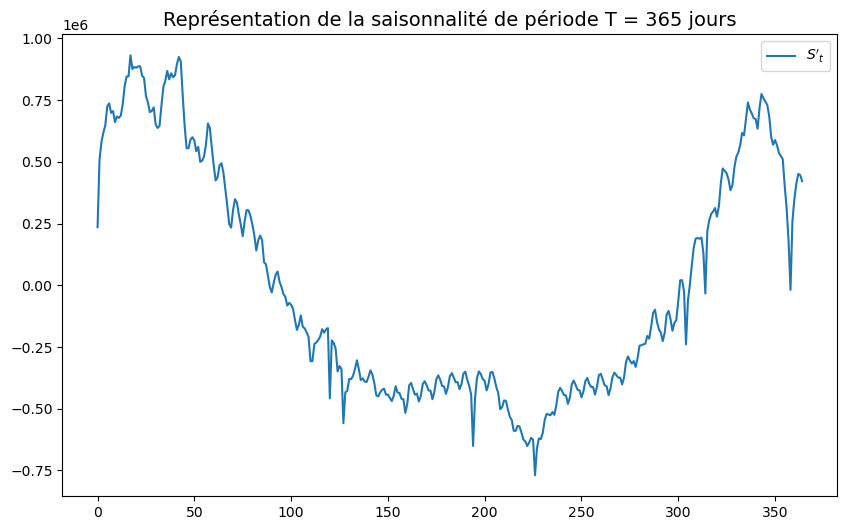

In [104]:
# on a donc notre S(t) de période 365 
plt.figure(figsize=(10, 6))
plt.plot(periode["Consommation brute d'électricité (MW)"], label="$S'_{t}$")
plt.title("Représentation de la saisonnalité de période T = 365 jours", fontsize=14)
plt.legend()
plt.show()

In [105]:
# maintenant que l'on a notre f(t) et notre S(t), on enlève la periodicité pour obtenir une série stationnaire

# Fusionner les deux DataFrames sur la colonne 'Jour-Mois'
merged_df = pd.merge(data_train_without_trend_copy, daily_sum, on='Jour-Mois', how='left')

# Créer une nouvelle colonne en soustrayant 'Consommation brute d'électricité (MW)_y' de 'Consommation brute d'électricité (MW)_x'
data_stationnaire = merged_df["Consommation brute d'électricité (MW)_x"] - merged_df["Consommation brute d'électricité (MW)_y"]

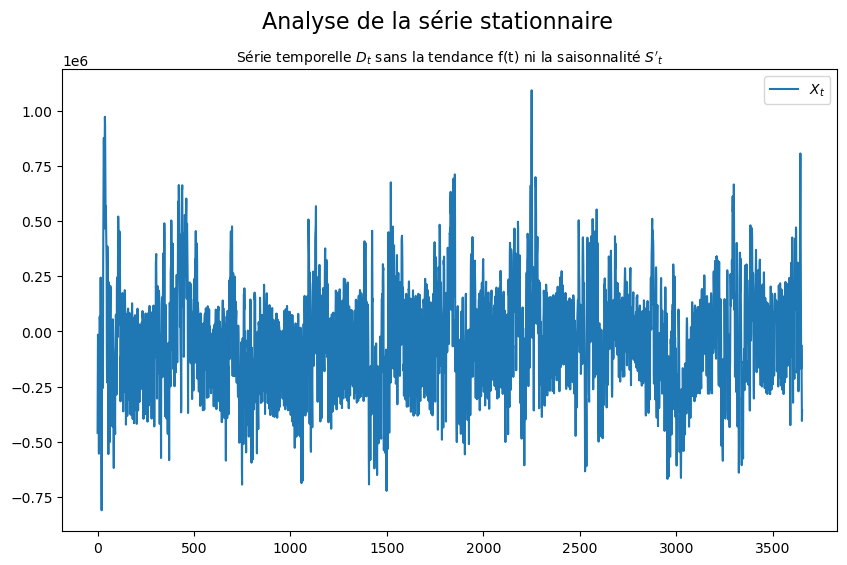

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(data_stationnaire, label='$X_{t}$')
plt.title("Série temporelle $D_{t}$ sans la tendance f(t) ni la saisonnalité $S'_{t}$", fontsize=10)
plt.suptitle("Analyse de la série stationnaire", fontsize=16)
plt.legend()
plt.show()

D:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


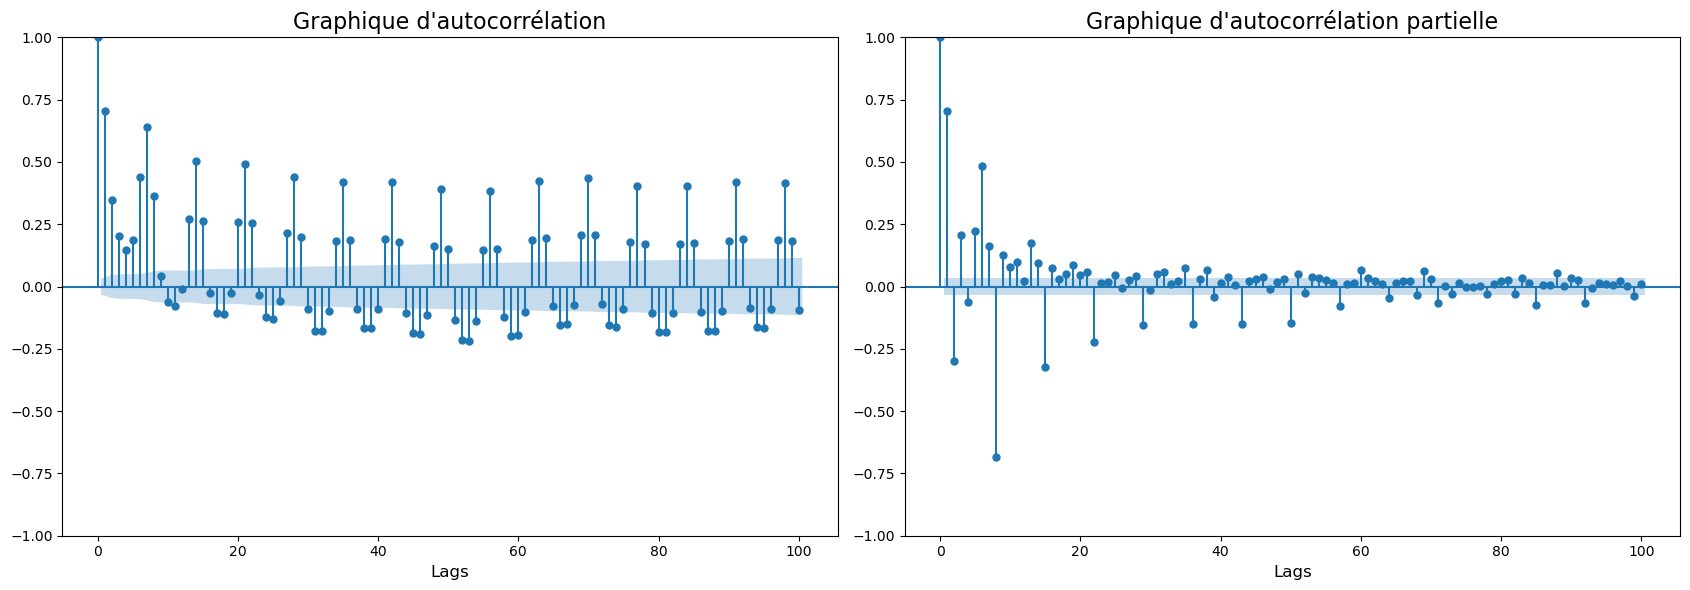

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))

# Premier sous-graphique
plot_acf(data_stationnaire, lags=100, ax=axs[0])  # Utiliser axs[0] au lieu de axs[1]
axs[0].set_title("Graphique d'autocorrélation", fontsize=16)
axs[0].set_xlabel('Lags', fontsize=12)

# Deuxième sous-graphique
plot_pacf(data_stationnaire, lags=100, ax=axs[1])
axs[1].set_title("Graphique d'autocorrélation partielle", fontsize=16)
axs[1].set_xlabel('Lags', fontsize=12)

plt.tight_layout()
plt.show()

In [108]:
# On observe encore une petite saisonalité de période 7 donc on va enlenver la saisonalité sur les jours de la semaine

In [109]:
data_stationnaire2 = data_stationnaire.copy()
data_stationnaire2 = pd.concat([data_final_train['Date'].reset_index()['Date'], data_stationnaire2], axis=1)
data_stationnaire2.rename(columns={0: "Consommation brute d'électricité (MW)"}, inplace=True)

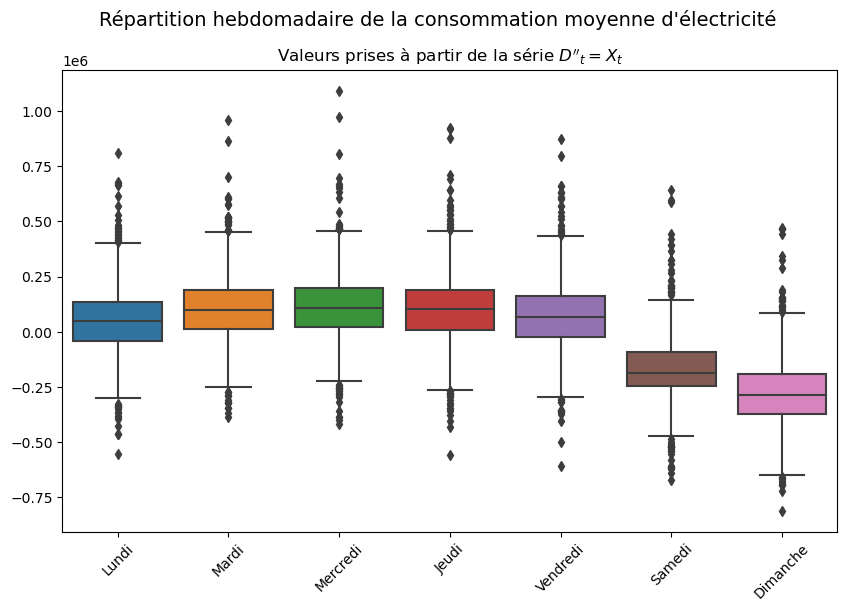

In [110]:
new_data_stationnaire2 = data_stationnaire2.copy()

new_data_stationnaire2['Date'] = pd.to_datetime(new_data_stationnaire2['Date'])

# Créer une nouvelle colonne pour le jour de la semaine (0 = Lundi, 1 = Mardi, ..., 6 = Dimanche)
new_data_stationnaire2['Day_of_Week'] = new_data_stationnaire2['Date'].dt.dayofweek

# Tracé du diagramme de dispersion par jour de la semaine
plt.figure(figsize=(10, 6))
sns.boxplot(x=new_data_stationnaire2['Day_of_Week'], y=new_data_stationnaire2["Consommation brute d'électricité (MW)"])
plt.title("Valeurs prises à partir de la série $D''_{t}=X_{t}$", fontsize=12)
plt.suptitle("Répartition hebdomadaire de la consommation moyenne d'électricité", fontsize=14)
plt.xticks(range(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [111]:
for i in range(7):
    num = new_data_stationnaire2.loc[new_data_stationnaire2['Day_of_Week'] == i].shape[0]
    jour = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'][i]
    print("Il y a", num, jour, "de janvier 2012 à décembre 2021.")

Il y a 522 Lundi de janvier 2012 à décembre 2021.
Il y a 522 Mardi de janvier 2012 à décembre 2021.
Il y a 522 Mercredi de janvier 2012 à décembre 2021.
Il y a 522 Jeudi de janvier 2012 à décembre 2021.
Il y a 522 Vendredi de janvier 2012 à décembre 2021.
Il y a 521 Samedi de janvier 2012 à décembre 2021.
Il y a 522 Dimanche de janvier 2012 à décembre 2021.


In [112]:
daily_sum = new_data_stationnaire2.groupby('Day_of_Week')["Consommation brute d'électricité (MW)"].sum().reset_index()

In [113]:
moyennes = np.zeros(7)
num = 522
for i in range(7):
    if i != 5:
        moyennes[i] = daily_sum["Consommation brute d'électricité (MW)"][i] / num
    else:
        moyennes[i] = daily_sum["Consommation brute d'électricité (MW)"][i] / 521

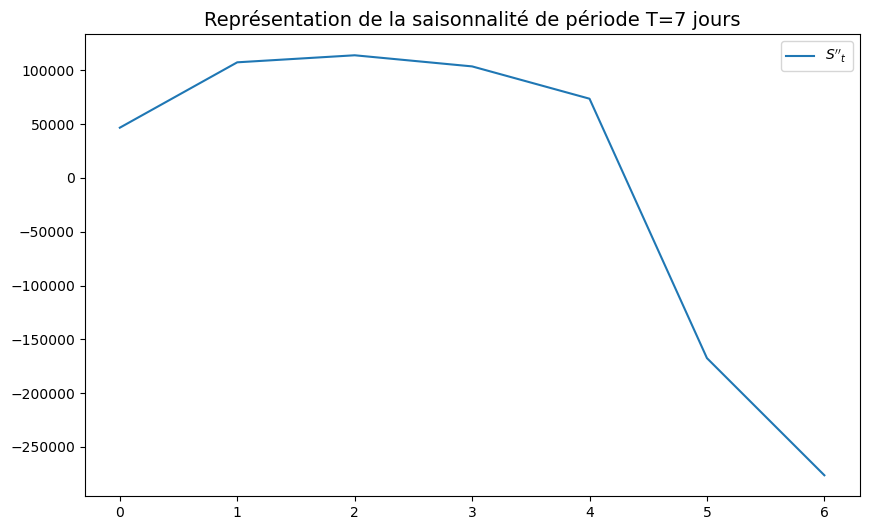

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(moyennes, label="$S''_{t}$")
plt.title("Représentation de la saisonnalité de période T=7 jours", fontsize=14)
#plt.xticks(range(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], rotation=45)
plt.legend()
plt.show()

In [115]:
# on prépare un tableau pour pouvoir enlever la moyenne à chaque valeur

moyennes = pd.concat([daily_sum["Day_of_Week"], pd.Series(moyennes)], axis=1)
moyennes.rename(columns={0: "moyenne"}, inplace=True)

# maintenant on fusionne les deux tableaux grâce à la colonne "Day_of_Week"
fusion = pd.merge(new_data_stationnaire2, moyennes, on='Day_of_Week')

# on le remet dans le bon ordre

fusion = fusion.sort_values(by='Date')
fusion = fusion.reset_index(drop=True)

In [116]:
data_stationnaire3 = fusion["Consommation brute d'électricité (MW)"] - fusion['moyenne']

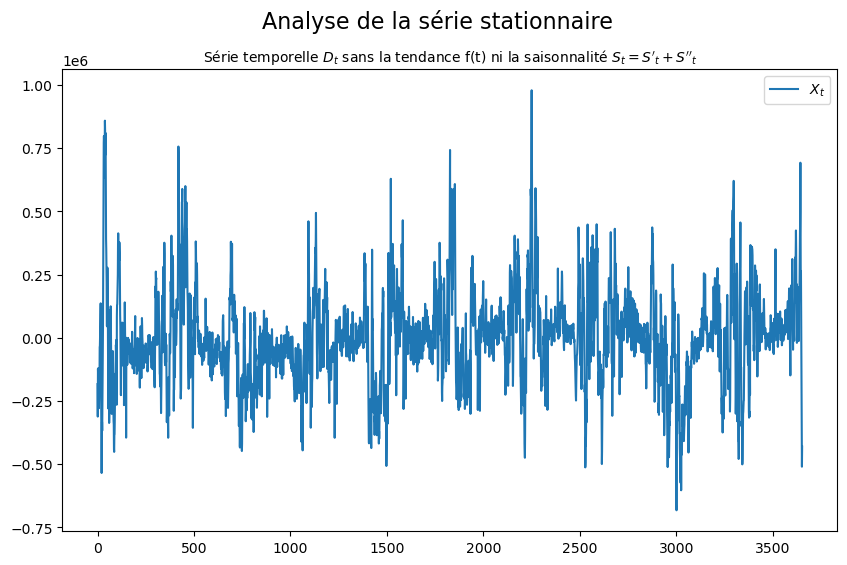

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(data_stationnaire3, label='$X_{t}$')
plt.title("Série temporelle $D_{t}$ sans la tendance f(t) ni la saisonnalité $S_{t}=S'_{t}+S''_{t}$", fontsize=10)
plt.suptitle("Analyse de la série stationnaire", fontsize=16)
plt.legend()
plt.show()

D:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


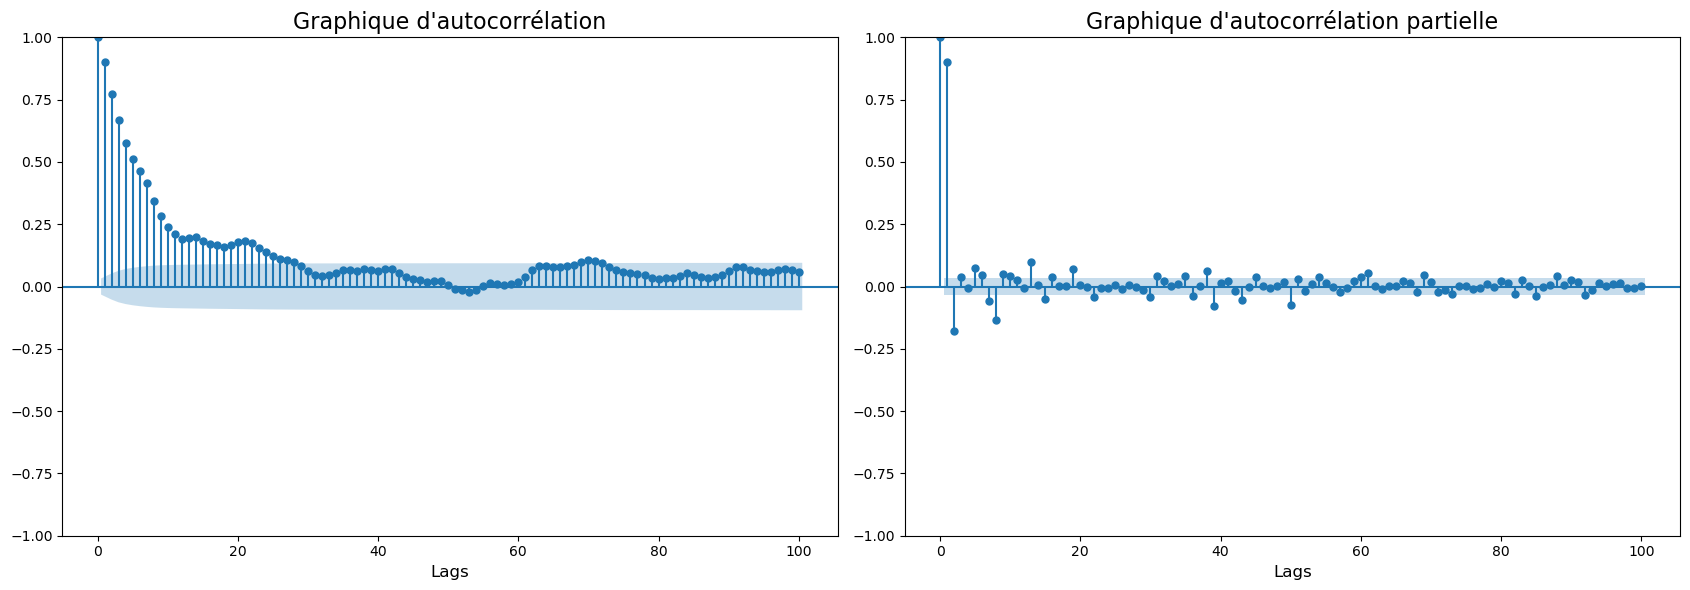

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))

# Premier sous-graphique
plot_acf(data_stationnaire3, lags=100, ax=axs[0])  # Utiliser axs[0] au lieu de axs[1]
axs[0].set_title("Graphique d'autocorrélation", fontsize=16)
axs[0].set_xlabel('Lags', fontsize=12)

# Deuxième sous-graphique
plot_pacf(data_stationnaire3, lags=100, ax=axs[1])
axs[1].set_title("Graphique d'autocorrélation partielle", fontsize=16)
axs[1].set_xlabel('Lags', fontsize=12)

plt.tight_layout()
plt.show()

In [119]:
# On observe que c'est un AR(2)

In [120]:
#tests de stationarité à détailler

In [121]:
result = adfuller(data_stationnaire3)

print('Statistique ADF :', result[0])
print('p-value :', result[1])
print('Nombre de lags utilisés :', result[2])
print("Nombre d'observations :", result[3])
print('Valeurs critiques :', result[4])

Statistique ADF : -9.065033858098369
p-value : 4.456401858434115e-15
Nombre de lags utilisés : 21
Nombre d'observations : 3631
Valeurs critiques : {'1%': -3.4321522387754775, '5%': -2.862336328589075, '10%': -2.567193897993964}


In [122]:
p, q = 2, 0
model = sm.tsa.ARIMA(data_stationnaire3, order=(p, 0, q))
result = model.fit()
print('phi_1 =', result.arparams[0])
print('phi_2 =', result.arparams[1])

phi_1 = 1.05935492276652
phi_2 = -0.17689483686949603


In [123]:
print('sigma^2 =', result.params[2])

sigma^2 = -0.17689483686949603


In [124]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3653
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -46389.289
Date:                Sun, 17 Dec 2023   AIC                          92786.578
Time:                        18:32:23   BIC                          92811.391
Sample:                             0   HQIC                         92795.414
                               - 3653                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.173e-09   1.12e+04  -3.71e-13      1.000    -2.2e+04     2.2e+04
ar.L1          1.0594      0.010    110.355      0.000       1.041       1.078
ar.L2         -0.1769      0.010    -17.036      0.000      -0.197      -0.157
sigma2      6.269e+09      0.051   1.24e+11      0.000    6.27e+09    6.27e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              2598.07
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.05
Prob(H) (two-sided):                  0.33   Kurtosis:                         7.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+26. Standard errors may be unstable.
"""

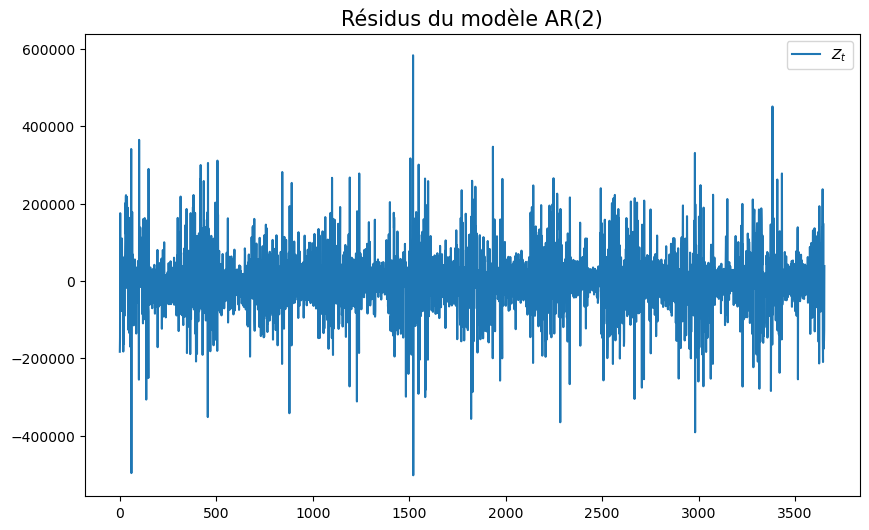

In [125]:
residus = result.resid

plt.figure(figsize=(10, 6))
plt.plot(residus, label='$Z_{t}$')
plt.title("Résidus du modèle AR(2)", fontsize=15)
plt.legend()
plt.show()

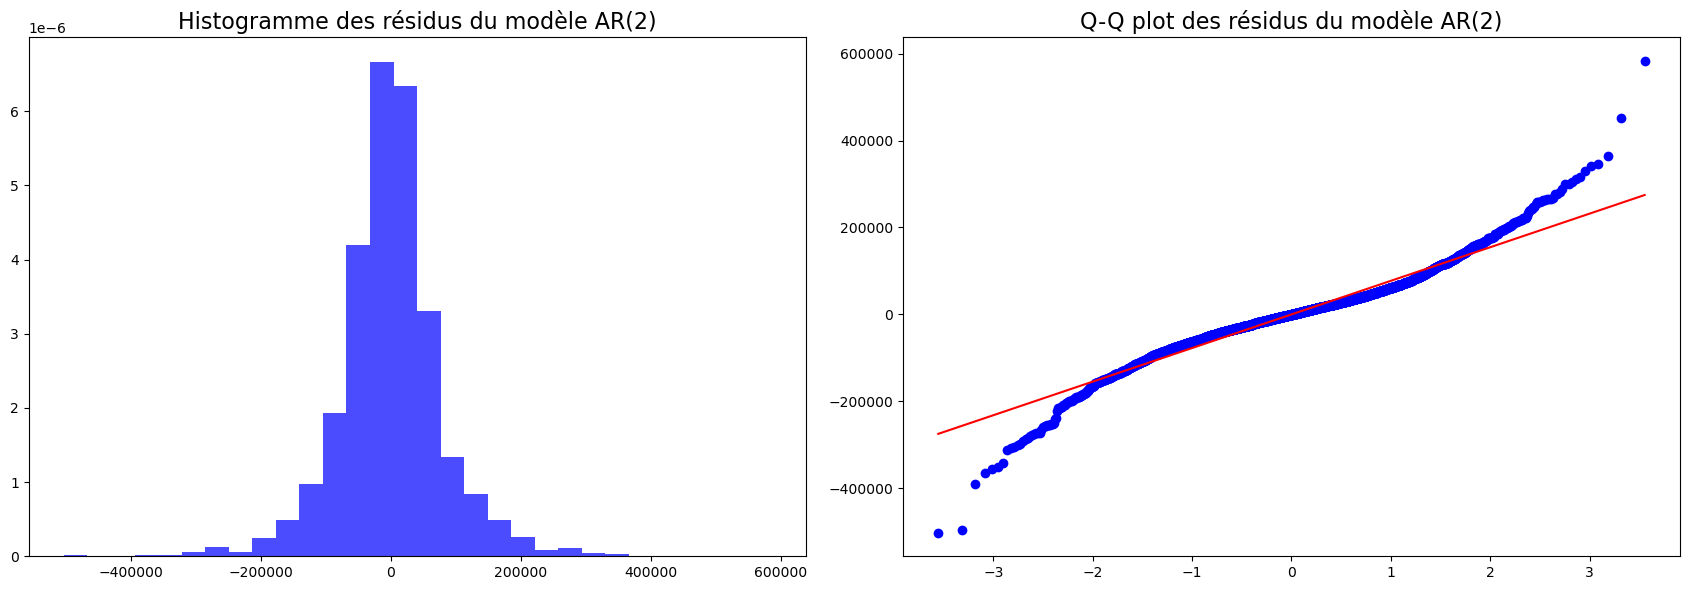

In [126]:
residus = result.resid

fig, axs = plt.subplots(1, 2, figsize=(17, 6))

# Tracer l'histogramme des résidus
axs[0].hist(residus, bins=30, density=True, alpha=0.7, color='b')
axs[0].set_title('Histogramme des résidus du modèle AR(2)', fontsize=16)

# Q-Q plot des résidus
stats.probplot(residus, dist="norm", plot=plt)
axs[1].set_title('Q-Q plot des résidus du modèle AR(2)', fontsize=16)
axs[1].set_ylabel('')
axs[1].set_xlabel('')


# Ajuster la disposition pour éviter les chevauchements
plt.tight_layout()

# Afficher les graphiques
plt.show()

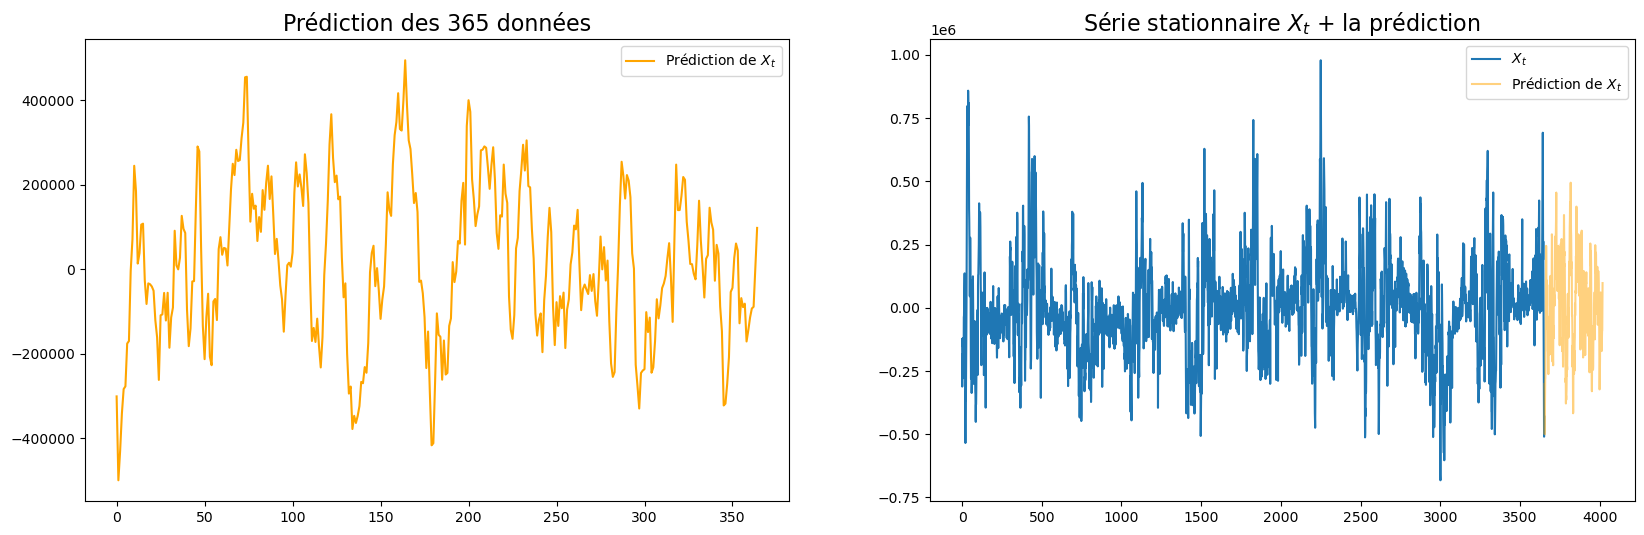

In [127]:
np.random.seed(1)

# Simulation des valeurs
simulated_values = result.simulate(steps=365, nsimulations=365)
simulated_values.index += len(data_stationnaire3) + 1

# Tracer les données d'entraînement et les valeurs simulées à droite
plt.figure(figsize=(20, 6))  # Augmenter la taille de la figure pour accueillir les deux graphiques

# Premier graphique à droite
plt.subplot(1, 2, 2)
plt.plot(data_stationnaire3, label='$X_{t}$')
plt.plot(simulated_values.index, simulated_values, label='Prédiction de $X_{t}$', color='orange', alpha=0.5)
plt.title("Série stationnaire $X_{t}$ + la prédiction", fontsize=16)
plt.legend()

# Réinitialiser la graine aléatoire
np.random.seed(1)

# Deuxième graphique à gauche
plt.subplot(1, 2, 1)
simulated_values_second = result.simulate(steps=365, nsimulations=365)
plt.plot(simulated_values_second, color='orange', label='Prédiction de $X_{t}$')
plt.title("Prédiction des 365 données", fontsize=16)
plt.legend()

plt.show()

In [128]:
periode = periode["Consommation brute d'électricité (MW)"]
periode.index += 3654
prediction = y_fore + periode + simulated_values

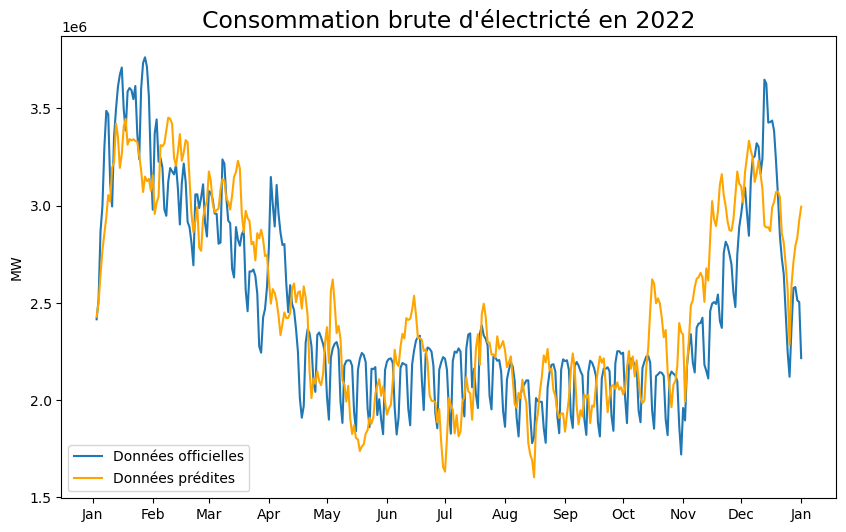

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(data_final_test["Consommation brute d'électricité (MW)"], label="Données officielles")
plt.plot(prediction, label="Données prédites", color='orange')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.legend()
plt.title("Consommation brute d'électricté en 2022", fontsize=17)
plt.ylabel('MW')
plt.show()

In [130]:
data_fii = data_fi.copy()
data_fii['Date - Heure'] = pd.to_datetime(data_fii['Date - Heure'])
date_debut = '2012-01-01'
date_fin = '2022-12-31'
data_final2 = data_fii.loc[(data_fi['Date - Heure'] >= date_debut) & (data_fii['Date - Heure'] <= date_fin)]

data_final2 = data_final2.copy()
data_final2.rename(columns={'Date - Heure': 'Date'}, inplace=True)

data_final2 = data_final2.copy()
data_final2.rename(columns={"Consommation brute électricité (MW) - RTE": "Consommation brute d'électricité (MW)"}, inplace=True)

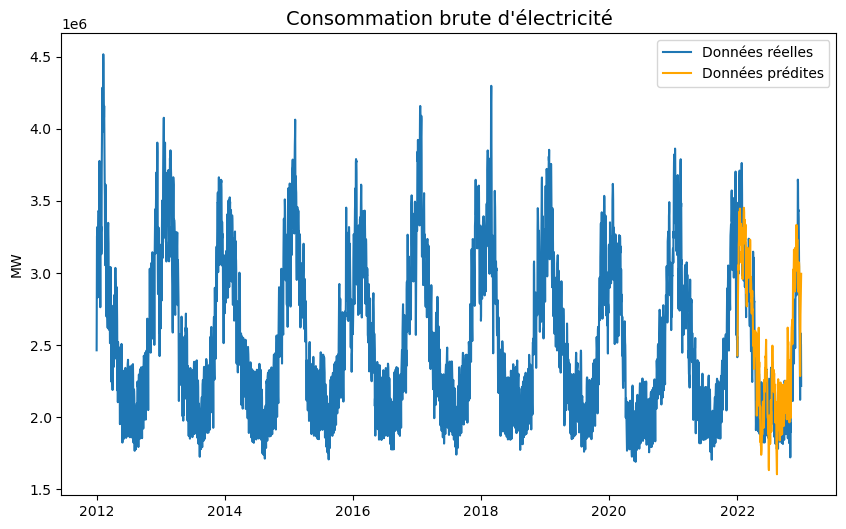

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(data_final2['Date'], data_final2["Consommation brute d'électricité (MW)"], label="Données réelles")
plt.plot(data_final_test['Date'], prediction, label="Données prédites", color='orange')
plt.ylabel('MW')
plt.title("Consommation brute d'électricité", fontsize=14)
plt.legend()
plt.show()

In [132]:
mse = mean_squared_error(data_final_test["Consommation brute d'électricité (MW)"], prediction)
print("MSE =", mse)

MSE = 84447442979.32533


In [133]:
#normalisations

In [134]:
from sklearn.preprocessing import StandardScaler

In [135]:
prediction_norm = prediction.copy()
data_final_test_norm = data_final_test["Consommation brute d'électricité (MW)"].copy()

In [136]:
prediction_norm = prediction_norm.values
data_final_test_norm = data_final_test_norm.values

In [137]:
prediction_norm = prediction_norm.reshape(-1, 1)
data_final_test_norm = data_final_test_norm.reshape(-1, 1)

In [138]:
sc1 = StandardScaler()
sc2 = StandardScaler()
prediction_norm = sc1.fit_transform(prediction_norm)
data_final_test_norm = sc1.fit_transform(data_final_test_norm)

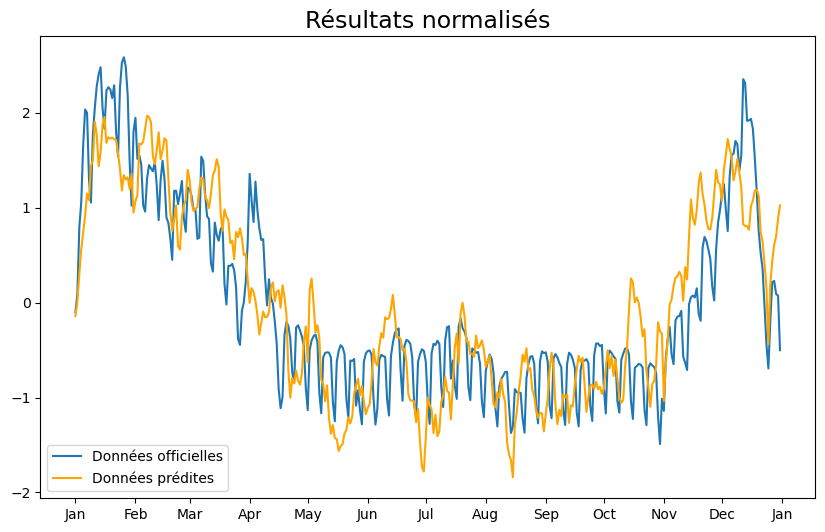

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(data_final_test_norm, label="Données officielles")
plt.plot(prediction_norm, label="Données prédites", color='orange')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.legend()
plt.title("Résultats normalisés", fontsize=17)
plt.show()

In [140]:
mse = mean_squared_error(data_final_test_norm, prediction_norm)
print("MSE =", mse)

MSE = 0.3428202925953447
